In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [4]:
train_features = np.load('../Data/UCI_train_features.npy')
test_features = np.load('../Data/UCI_test_features.npy')
train_labels = np.load('../Data/UCI_train_labels.npy')
test_labels = np.load('../Data/UCI_test_labels.npy')

In [5]:
train_labels = train_labels - 1
test_labels = test_labels - 1

In [6]:
tensor_train_features = torch.Tensor(train_features)
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features)
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=32,shuffle=True)

## 2 layers with kernerl_size = 3

In [35]:
# num_feature = 9
# feature_width = 128
# kernel_size = 2

#
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU())
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(12768, 500)
        self.fc2 = nn.Linear(500, 6)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = CNN_1().to(device)

epoches = 15
lr = 0.001
weight_decay = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=lr, weight_decay=weight_decay)

In [37]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,36)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_1(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  71.87159956474429  % Loss:  1.6626110982311808
Epoch:  2 accuracy:  82.44015233949946  % Loss:  0.47157552303827327
Epoch:  3 accuracy:  83.7867247007617  % Loss:  0.4431917309113171
Epoch:  4 accuracy:  85.24211099020674  % Loss:  0.4065775168006835
Epoch:  5 accuracy:  85.02448313384113  % Loss:  0.4002727435982746
Epoch:  6 accuracy:  85.18770402611534  % Loss:  0.3964846362562283
Epoch:  7 accuracy:  86.33025027203482  % Loss:  0.3758435803263084
Epoch:  8 accuracy:  85.78618063112079  % Loss:  0.38960091678992564
Epoch:  9 accuracy:  86.33025027203482  % Loss:  0.38171899824038796
Epoch:  10 accuracy:  86.05821545157781  % Loss:  0.3818367587483448
Epoch:  11 accuracy:  86.34385201305767  % Loss:  0.37846272853405577
Epoch:  12 accuracy:  86.6158868335147  % Loss:  0.3765899907635606
Epoch:  13 accuracy:  86.41186071817192  % Loss:  0.3722501964348814
Epoch:  14 accuracy:  85.84058759521218  % Loss:  0.3812672497137733
Epoch:  15 accuracy:  86.86071817192601  

In [38]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():
      for (imgs_test,labels_test) in test_loader:
        imgs_test = imgs_test.reshape(len(imgs_test),1,32,36)
        imgs_test = imgs_test.to(device)
        
        labels_test = labels_test.type(torch.LongTensor)
        labels_test = labels_test.to(device)

        outputs_test = model_1(imgs_test)
        labels_test = labels_test.reshape(labels_test.shape[0],)
        predicted_test = torch.max(outputs_test.data,1)[1]
      
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        test_accuracy = 100*correct_test/total_test

print('test accuracy is: ',test_accuracy)

test accuracy is:  79.33491686460808


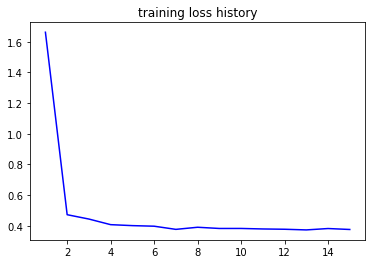

In [39]:
import matplotlib.pyplot as plt
x = []
for i in range(1,16):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

## 2 layers with kernerl_size = 5

In [41]:
# num_feature = 9
# feature_width = 128
# kernel_size = 2

#
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(9216, 500)
        self.fc2 = nn.Linear(500, 6)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_2 = CNN_2().to(device)

epoches = 15
lr = 0.001
weight_decay = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)

In [43]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,36)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_2(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  70.18498367791078  % Loss:  1.2964049818723098
Epoch:  2 accuracy:  80.83514689880305  % Loss:  0.5009440429184748
Epoch:  3 accuracy:  84.24918389553864  % Loss:  0.4271845673089442
Epoch:  4 accuracy:  83.97714907508161  % Loss:  0.4156005214089933
Epoch:  5 accuracy:  85.09249183895538  % Loss:  0.3813711926017119
Epoch:  6 accuracy:  85.60935799782372  % Loss:  0.3716955223809118
Epoch:  7 accuracy:  86.49347116430903  % Loss:  0.3409122241579968
Epoch:  8 accuracy:  87.07834602829162  % Loss:  0.34417416910114496
Epoch:  9 accuracy:  86.79270946681176  % Loss:  0.34629307567425394
Epoch:  10 accuracy:  87.54080522306856  % Loss:  0.33649568434642707
Epoch:  11 accuracy:  86.90152339499456  % Loss:  0.33298148956635726
Epoch:  12 accuracy:  86.99673558215451  % Loss:  0.3349914050620535
Epoch:  13 accuracy:  87.5544069640914  % Loss:  0.32814345780922016
Epoch:  14 accuracy:  87.40478781284004  % Loss:  0.3204535435723222
Epoch:  15 accuracy:  87.18715995647443

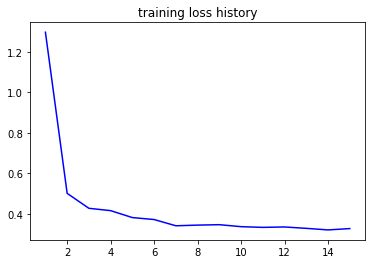

In [44]:
import matplotlib.pyplot as plt
x = []
for i in range(1,16):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [45]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():
      for (imgs_test,labels_test) in test_loader:
        imgs_test = imgs_test.reshape(len(imgs_test),1,32,36)
        imgs_test = imgs_test.to(device)
        
        labels_test = labels_test.type(torch.LongTensor)
        labels_test = labels_test.to(device)

        outputs_test = model_2(imgs_test)
        labels_test = labels_test.reshape(labels_test.shape[0],)
        predicted_test = torch.max(outputs_test.data,1)[1]
      
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        test_accuracy = 100*correct_test/total_test

print('test accuracy is: ',test_accuracy)

test accuracy is:  81.54054971157109


## 3 layers with kernerl_size = 3

In [57]:
# num_feature = 9
# feature_width = 128
# kernel_size = 2

#
class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU()
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(30912, 512)
        self.fc3 = nn.Linear(512, 6)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_3 = CNN_3().to(device)

epoches = 15
lr = 0.001
weight_decay = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=lr, weight_decay=weight_decay)

In [59]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,36)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_3(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  77.2442872687704  % Loss:  0.8633785092312357
Epoch:  2 accuracy:  85.21490750816105  % Loss:  0.40805489845249965
Epoch:  3 accuracy:  85.71817192600653  % Loss:  0.3813986483475436
Epoch:  4 accuracy:  86.46626768226334  % Loss:  0.36015337948565895
Epoch:  5 accuracy:  86.54787812840044  % Loss:  0.35744648844651555
Epoch:  6 accuracy:  86.6974972796518  % Loss:  0.3433948241012252
Epoch:  7 accuracy:  87.22796517954298  % Loss:  0.3345272103729455
Epoch:  8 accuracy:  87.69042437431992  % Loss:  0.3237963777197444
Epoch:  9 accuracy:  88.39771490750816  % Loss:  0.3099410955996617
Epoch:  10 accuracy:  88.03046789989119  % Loss:  0.30388745659071464
Epoch:  11 accuracy:  87.81284004352557  % Loss:  0.31600110534092657
Epoch:  12 accuracy:  88.32970620239391  % Loss:  0.3024260829810215
Epoch:  13 accuracy:  88.84657236126225  % Loss:  0.28911827527310535
Epoch:  14 accuracy:  88.65614798694233  % Loss:  0.2942570005584022
Epoch:  15 accuracy:  89.32263329706203

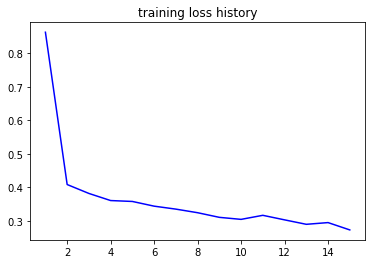

In [60]:
import matplotlib.pyplot as plt
x = []
for i in range(1,16):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [61]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():
      for (imgs_test,labels_test) in test_loader:
        imgs_test = imgs_test.reshape(len(imgs_test),1,32,36)
        imgs_test = imgs_test.to(device)
        
        labels_test = labels_test.type(torch.LongTensor)
        labels_test = labels_test.to(device)

        outputs_test = model_3(imgs_test)
        labels_test = labels_test.reshape(labels_test.shape[0],)
        predicted_test = torch.max(outputs_test.data,1)[1]
      
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        test_accuracy = 100*correct_test/total_test

print('test accuracy is: ',test_accuracy)

test accuracy is:  83.20325755005089


## 3 layers with kernerl_size = 5

In [69]:
# num_feature = 9
# feature_width = 128
# kernel_size = 2

#
class CNN_4(nn.Module):
    def __init__(self):
        super(CNN_4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(18432, 512)
        self.fc3 = nn.Linear(512, 6)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_4 = CNN_4().to(device)

epoches = 15
lr = 0.001
weight_decay = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=lr, weight_decay=weight_decay)

In [71]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,36)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_4(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  79.82861806311207  % Loss:  0.7690656593312388
Epoch:  2 accuracy:  86.84711643090316  % Loss:  0.3518418017288913
Epoch:  3 accuracy:  88.27529923830251  % Loss:  0.31279562782982123
Epoch:  4 accuracy:  88.26169749727966  % Loss:  0.3106164123377074
Epoch:  5 accuracy:  88.54733405875952  % Loss:  0.2847427765312402
Epoch:  6 accuracy:  89.45865070729053  % Loss:  0.285028607122924
Epoch:  7 accuracy:  88.80576713819369  % Loss:  0.2844672589522341
Epoch:  8 accuracy:  89.56746463547334  % Loss:  0.27122323704154594
Epoch:  9 accuracy:  89.52665941240478  % Loss:  0.2720216773612344
Epoch:  10 accuracy:  89.54026115342764  % Loss:  0.26365167527743005
Epoch:  11 accuracy:  90.26115342763873  % Loss:  0.25231804115616757
Epoch:  12 accuracy:  89.89390642002176  % Loss:  0.2611407492795716
Epoch:  13 accuracy:  90.75081610446136  % Loss:  0.2481404550211585
Epoch:  14 accuracy:  90.13873775843308  % Loss:  0.25700056931084914
Epoch:  15 accuracy:  90.09793253536452

In [73]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():
      for (imgs_test,labels_test) in test_loader:
        imgs_test = imgs_test.reshape(len(imgs_test),1,32,36)
        imgs_test = imgs_test.to(device)
        
        labels_test = labels_test.type(torch.LongTensor)
        labels_test = labels_test.to(device)

        outputs_test = model_4(imgs_test)
        labels_test = labels_test.reshape(labels_test.shape[0],)
        predicted_test = torch.max(outputs_test.data,1)[1]
      
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        test_accuracy = 100*correct_test/total_test

print('test accuracy is: ',test_accuracy)

test accuracy is:  81.9816762809637


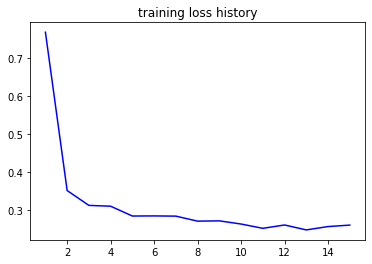

In [74]:
import matplotlib.pyplot as plt
x = []
for i in range(1,16):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()